**二维阻尼振荡器**

作为第一个说明性示例，我们考虑具有三次动态的二维阻尼谐振子，即：

$$
\begin{array}{l}
\dot{x} = -0.1\ x^3 + 2.0\ y^3,\\
\dot{y} = -2.0\ x^3 - 0.1\ y^3.
\end{array}
$$

我们使用初始条件 $[x_0\ y_0]^T = [2\ 0]^T$，并从 $t = 0$ 到 $t = 25$ 收集数据，时间步长为 $\Delta t = 0.01$。数据绘制在下图中。我们使用一个具有一层隐藏层和256个神经元的神经网络来表示非线性动力学。对于多步方案，我们采用 $M=1$ 步长的 Adams-Moulton 方法（即梯形规则）。在训练神经网络之后，我们使用与上述相同的初始条件求解识别出的系统。下图定性地评估了识别正确非线性动力学的准确性。具体来说，通过比较系统的精确轨迹和预测轨迹以及所得的相图，我们可以看到算法能够正确捕捉到系统的动态演变。

> _谐振子：_ 左侧面板显示了具有三次动态的二维阻尼谐振子的轨迹，而右侧面板绘制了相应的相图。彩色实线表示精确的动力学，虚线表示学习到的动力学。识别出的系统能够正确捕捉动力学形式，并准确再现相图。

In [1]:
import numpy as np
from scipy.integrate import odeint
from Multistep_NN import Multistep_NN
from plotting import newfig, savefig
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import time

# define solution
def phi(r):
    if 0 <= r <= 1:
        return 1
    else:
        return 0
# def phi(r):
#     # 计算 1/sqrt(2)
#     sqrt2_inv = 1 / np.sqrt(2)
#     # 初始化 phi 为 0
#     phi_values = np.zeros_like(r)
#     # 对于 r 在 [0, 1/sqrt(2]] 区间内，phi(r) = 0.1
#     phi_values[(r >= 0) & (r <= sqrt2_inv)] = 0.1
#     # 对于 r 在 (1/sqrt(2), 1] 区间内，phi(r) = 1
#     phi_values[(r > sqrt2_inv) & (r <= 1)] = 1
#     return phi_values

torch.manual_seed(0)
if __name__ == "__main__": 
    
    def f(x, t, alpha=1, N=50):
            # 假设 x 是一维数组，包含 N 个标量 x_i
            f = np.zeros(N)  # 初始化 dx/dt，形状为 (N,)
            
            for i in range(N):
                phi_ik_sum = sum(phi(abs(x[k] - x[i])) for k in range(N) if k != i)
                for j in range(N):
                    if i != j:
                        # 计算 x_j - x_i
                        diff = x[j] - x[i]
                        phi_ij = phi(abs(diff))
                        # 计算 a_ij = phi_ij / sum(phi_ik)
                        if phi_ik_sum != 0:
                            a_ij = phi_ij / phi_ik_sum
                        else:
                            a_ij = 0  # 如果分母为 0，则 a_ij 为 0
                        # 累加 alpha * a_ij * (x_j - x_i) 到 f[i]
                        f[i] += alpha * a_ij * diff
            
            return f.flatten()  # 返回一维数组
    
    # time points
    n_steps = 10000
    # t_star = np.arange(0,25,0.01)
    t_star = np.linspace(0, 10, num=n_steps)
    # initial condition
    # x0 = np.array([2,0])
    # x0 = np.random.uniform(0, 10, 50)
    x0 = np.array([5.55556439, 6.1202558 , 1.31589088, 4.17806003, 7.34753466,
       7.12816785, 9.06880371, 1.29676763, 3.42225157, 5.43237047,
       0.11059067, 7.80974994, 6.03670891, 0.81373324, 3.246417  ,
       4.60066361, 1.68067959, 3.98806168, 7.98200535, 0.50534268,
       1.50309975, 4.42313428, 1.44786952, 3.1469025 , 2.39320796,
       6.69964605, 7.46626908, 4.08491387, 4.63274641, 4.58568309,
       8.95743239, 3.0584266 , 5.00243975, 8.70777599, 2.27919911,
       1.04429653, 2.06838483, 3.14724888, 8.61008361, 4.92128717,
       9.977988  , 8.81160548, 8.56214329, 2.34193884, 2.56452312,
       9.95976192, 9.18023511, 8.96248071, 2.0985968 , 2.22661127]) 
    X_star = odeint(f, x0, t_star)
    noise = 0.00

    skip = 1
    dt = t_star[skip] - t_star[0]
    X_train = X_star[0::skip,:]
    X_train = X_train + noise*X_train.std(0)*np.random.randn(X_train.shape[0], X_train.shape[1])
    
    X_train = np.reshape(X_train, (1,X_train.shape[0],X_train.shape[1]))
    layers = [50, 612, 50]
    
    M = 1
    scheme = 'AM'
    model = Multistep_NN(dt, X_train, layers, M, scheme)
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.001,betas=(0.9, 0.999),  eps=1e-32)
    N_Iter = 2001
    
    times = []
    Train_loss_list = []
    iteration_list = []
    target_loss = 1e-10

    start_time = time.time()
    for epoch in range(N_Iter):
        model.train()       
        optimizer.zero_grad()
        Y_pred = model.forward(model.X)
        # loss = self.D * loss_function(Y_pred, torch.zeros_like(Y_pred))
        loss = loss_function(Y_pred, torch.zeros_like(Y_pred))
        loss.backward()
        optimizer.step()
        current_time = time.time()
        iteration_time = current_time - start_time

        # 存储损失值和迭代次数
        times.append(iteration_time)
        Train_loss_list.append(loss.cpu().detach().numpy())
        iteration_list.append(epoch)
            
        # Print
        if epoch % 1000 == 0:
            # print(f'Epoch {epoch+1}/{N_Iter}, Train_loss: {loss.item(): .16e}, Time per iteration: {iteration_time:.4f} seconds')
            print(f'Epoch {epoch+1}/{N_Iter}, Train_loss: {loss.item(): .16e}')

        if loss.item() < target_loss:
            print(f'Target loss reached at iteration {epoch+1}.')
            break    


    def learned_f(x,t):
        f = model.predict_f(x[None,:])
        return f.flatten()
    
    learned_X_star = odeint(learned_f, x0, t_star)  
    

Epoch 1/2001, Train_loss:  2.7485776854518917e-07
Epoch 1001/2001, Train_loss:  1.8705308413302646e-09
Epoch 2001/2001, Train_loss:  8.9249341250763337e-10


In [2]:
Mean_loss = np.mean((learned_X_star-X_star)**2)  
l2_loss = np.sqrt(np.sum((learned_X_star-X_star)**2))
linf_loss = np.max(np.abs(learned_X_star-X_star))
print(f'Mean_loss: {Mean_loss.item(): .8e}, l2_loss: {l2_loss.item(): .8e}, linf_loss: {linf_loss.item(): .8e}')

Mean_loss:  9.66455055e-04, l2_loss:  2.19824368e+01, linf_loss:  1.59133698e-01


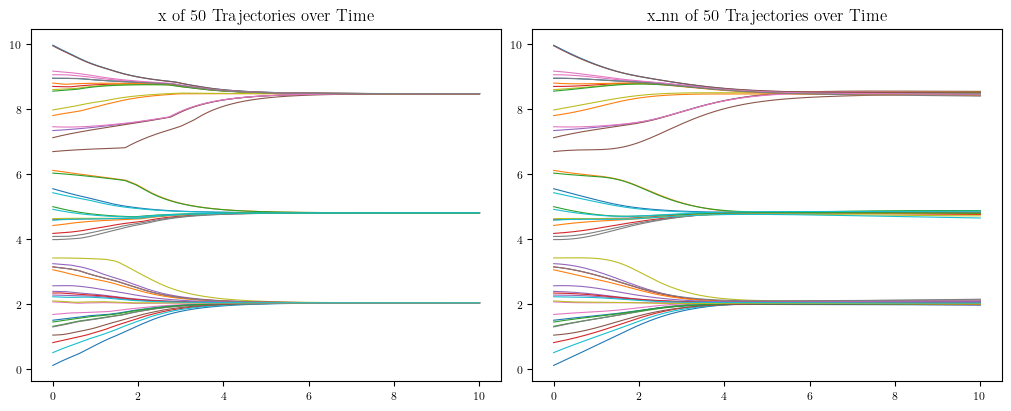

In [3]:
import matplotlib.pyplot as plt
# 创建图形
# plt.figure(figsize=(10, 6))

fig, axs = plt.subplots(1, 2, figsize=(10, 4), layout='constrained')

# 绘制每一条解
for i in range(50):
    axs[0].plot(t_star, X_star[:, i], linewidth=0.8)
axs[0].set_title('x of 50 Trajectories over Time') 

for i in range(50):
    axs[1].plot(t_star, learned_X_star[:, i], linewidth=0.8)
axs[1].set_title('x_nn of 50 Trajectories over Time')

# for i in range(50):
#     plt.plot(t_star, X_star[:, i], label=f'Solution {i+1}', linewidth=0.8)

# 图形的标题和标签

# plt.xlabel("Time")
# plt.ylabel("x values")
# plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1.0), fontsize='small', ncol=1, frameon=False)
plt.savefig('NN_Self_organized_13_10000_2001_0.001.png', format='png', dpi=600)

In [ ]:
data = np.genfromtxt('loss_time_data_5000_0.001.csv', delimiter=',', skip_header=1)


# 绘制迭代次数和误差的关系图
plt.figure(figsize=(10, 6))
# plt.plot(data[:2001,0], data[:2001,1], label='Train loss', color='b')
# plt.plot(iteration_list[:2001], Train_loss_list[:2001], label='Train loss', color='r')
plt.plot(data[:,0], data[:,1], label='KAN_loss', color='b')
plt.plot(iteration_list, Train_loss_list, label='NN_loss', color='r')
plt.yscale('log')
plt.ylim(10e-12, 10e-3)
plt.xlabel('Iteration')
plt.ylabel('Loss')
# plt.title('Loss vs. Iteration')
plt.legend()
plt.grid(True)
# plt.show()
plt.savefig('Cubic2D_Error_5000_0.001.png', format='png', dpi=600, bbox_inches='tight')

In [ ]:
# 绘制时间和误差的关系图
plt.figure(figsize=(10, 5))
plt.plot(times, Train_loss_list, label='Loss vs Time')
plt.yscale('log')
plt.xlabel('Time (seconds)')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.legend()
plt.show()

In [ ]:
####### Plotting ################## 
plt.figure(figsize=(10, 6))
plt.plot(t_star, learned_X_star[:,0], label='learned_y_1',linestyle='--', color='r')
plt.plot(t_star, learned_X_star[:,1], label='learned_y_2',linestyle='--', color='b')
plt.plot(t_star, X_star[:,0], label='y_1', color='g')
plt.plot(t_star, X_star[:,1], label='y_2', color='c')
plt.legend()
plt.show

In [ ]:
####### Plotting ################## 
fig, ax = newfig(1.0, 0.9)
ax.axis('off')

gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=0.85, bottom=0.25, left=0.1, right=0.95, wspace=0.3)

ax = plt.subplot(gs0[:, 0:1])
ax.plot(t_star,X_star[:,0],'r',label='$x$')
ax.plot(t_star,X_star[:,1],'b',label='$y$')
ax.plot(t_star,learned_X_star[:,0],'k--',label='learned model')
ax.plot(t_star,learned_X_star[:,1],'k--')    
ax.set_xlabel('$t$')
ax.set_ylabel('$x, y$')
ax.legend(loc='upper center', bbox_to_anchor=(0.9, -0.25), ncol=3, frameon=False)
ax.set_title('Trajectories', fontsize = 10)

ax = plt.subplot(gs0[:, 1:2])
ax.plot(X_star[:,0],X_star[:,1], 'm', label='$(x,y)$')
ax.plot(learned_X_star[:,0],learned_X_star[:,1],'k--')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.legend(loc='upper center', bbox_to_anchor=(0.4, -0.25), ncol=1, frameon=False)
ax.set_title('Phase Portrait', fontsize = 10)

savefig('./figures/Cubic2D')